# SBA Loan Default Prediction (MSBA 207)

**Objective**  
Predict small business loan defaults using the SBA dataset.  
Default misclassification costs are 5× higher than missed approvals.

**Models Compared**  
- Logistic Regression, Decision Trees, Random Forest, Gradient Boosting, Bagging, Neural Nets, LDA  

**Key Results**  
- **Bagging performed best**, achieving the highest net profit.  
- Lending to only the safest 70–75% of applicants maximized profit.  
- Recommended cutoff: grant loans only if `p_success ≥ 0.83`.  

**Business Impact**  
Using Bagging can significantly reduce financial losses by avoiding risky approvals, giving a clear operational rule for credit decisions.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score,precision_recall_fscore_support,
recall_score, confusion_matrix, f1_score, roc_curve)


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Visualizations
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
#Data Loading and Preprocessing 
# How is the outcome variable MIS_Status distributed? Identify predictors that may help predict MIS_Status using descriptive statistics and visualization. 
sba_df = pd.read_csv('/Users/gauribora/Downloads/Project/SBAnational.csv')
sba_df.shape

/var/folders/0l/zp3wpc151dngqk6wn_r8cgz80000gn/T/ipykernel_32285/3403216714.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  sba_df = pd.read_csv('/Users/gauribora/Downloads/Project/SBAnational.csv')


(899164, 27)

In [3]:
# Initial Exploration
print(sba_df.info())
print(sba_df["MIS_Status"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

In [4]:
# List of currency columns to clean
currency_cols = ['DisbursementGross', 'GrAppv', 'SBA_Appv']

for col in currency_cols:
    # Remove '$' and ',' characters using .str.replace() and convert to a numeric type.
    sba_df[col] = sba_df[col].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
    sba_df[col] = pd.to_numeric(sba_df[col], errors='coerce')
#Handle Missing Values 
missing_percentages = sba_df.isnull().mean()
cols_to_drop = missing_percentages[missing_percentages > 0.50].index.tolist()
if cols_to_drop:
    print(f"\nDropping columns with >50% missing values: {cols_to_drop}")
    sba_df.drop(columns=cols_to_drop, inplace=True)


Dropping columns with >50% missing values: ['ChgOffDate']


In [5]:
#changing variables 
sba_df['MIS_Status'] = sba_df['MIS_Status'].map({'P I F': 0, 'CHGOFF': 1})
sba_df['RevLineCr'] = sba_df['RevLineCr'].map({'Y': 1, 'N': 0}).fillna(-1)
sba_df['LowDoc'] = sba_df['LowDoc'].map({'Y': 1, 'N': 0}).fillna(-1)

#Dropping NA from Target 
sba_df.dropna(subset=['MIS_Status'], inplace=True)
sba_df.fillna(sba_df.mean(numeric_only=True), inplace=True)


In [6]:
print("\n 3.1: Exploration of the Outcome Variable (MIS_Status)")
status_counts = sba_df['MIS_Status'].value_counts()
status_percentages = sba_df['MIS_Status'].value_counts(normalize=True) * 100

print("\nCounts and percentages of loan statuses:")
print(status_counts)
print("\nPercentage distribution:")
print(status_percentages)



 3.1: Exploration of the Outcome Variable (MIS_Status)

Counts and percentages of loan statuses:
MIS_Status
0.0    739609
1.0    157558
Name: count, dtype: int64

Percentage distribution:
MIS_Status
0.0    82.438275
1.0    17.561725
Name: proportion, dtype: float64


/var/folders/0l/zp3wpc151dngqk6wn_r8cgz80000gn/T/ipykernel_32285/2098091101.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='MIS_Status', data=sba_df, palette=['#4e79a7', '#f28e2b'])


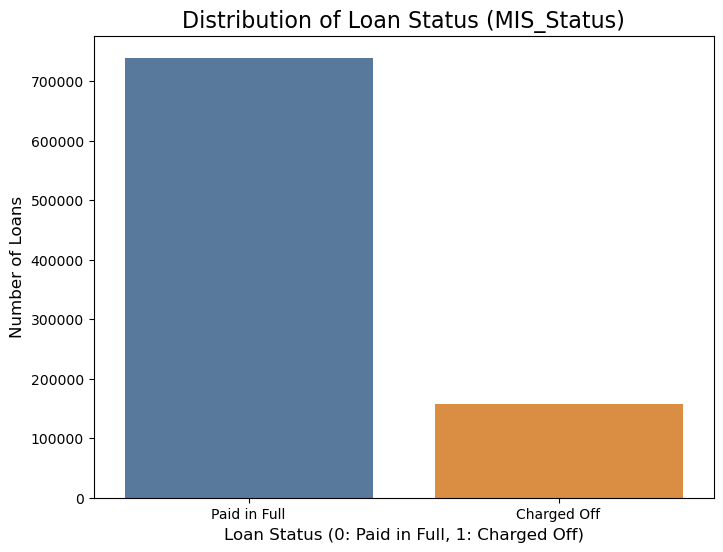

In [7]:
# Visualize the distribution using a bar chart
plt.figure(figsize=(8, 6))
sns.countplot(x='MIS_Status', data=sba_df, palette=['#4e79a7', '#f28e2b'])
plt.title('Distribution of Loan Status (MIS_Status)', fontsize=16)
plt.xlabel('Loan Status (0: Paid in Full, 1: Charged Off)', fontsize=12)
plt.ylabel('Number of Loans', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Paid in Full', 'Charged Off'])
plt.show()

In [8]:
#Numerical Predictors Analysis 
numerical_predictors = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'GrAppv', 'SBA_Appv']
print("\nDescriptive statistics of numerical predictors by loan status:")
print(sba_df.groupby('MIS_Status')[numerical_predictors].describe().T)



Descriptive statistics of numerical predictors by loan status:
MIS_Status                  0.0           1.0
Term        count  7.396090e+05  1.575580e+05
            mean   1.222878e+02  5.715045e+01
            std    7.966312e+01  4.647830e+01
            min    0.000000e+00  0.000000e+00
            25%    7.700000e+01  3.000000e+01
            50%    8.400000e+01  5.000000e+01
            75%    1.800000e+02  6.900000e+01
            max    5.690000e+02  4.610000e+02
NoEmp       count  7.396090e+05  1.575580e+05
            mean   1.230712e+01  7.213325e+00
            std    7.612546e+01  6.150800e+01
            min    0.000000e+00  0.000000e+00
            25%    2.000000e+00  2.000000e+00
            50%    5.000000e+00  3.000000e+00
            75%    1.100000e+01  7.000000e+00
            max    9.999000e+03  9.999000e+03
CreateJob   count  7.396090e+05  1.575580e+05
            mean   7.142802e+00  1.455382e+01
            std    2.100809e+02  3.353876e+02
            min 

/var/folders/0l/zp3wpc151dngqk6wn_r8cgz80000gn/T/ipykernel_32285/3744947983.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MIS_Status', y=col, data=sba_df, palette=['#4e79a7', '#f28e2b'])
/var/folders/0l/zp3wpc151dngqk6wn_r8cgz80000gn/T/ipykernel_32285/3744947983.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MIS_Status', y=col, data=sba_df, palette=['#4e79a7', '#f28e2b'])
/var/folders/0l/zp3wpc151dngqk6wn_r8cgz80000gn/T/ipykernel_32285/3744947983.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MIS_Status', y=col, data

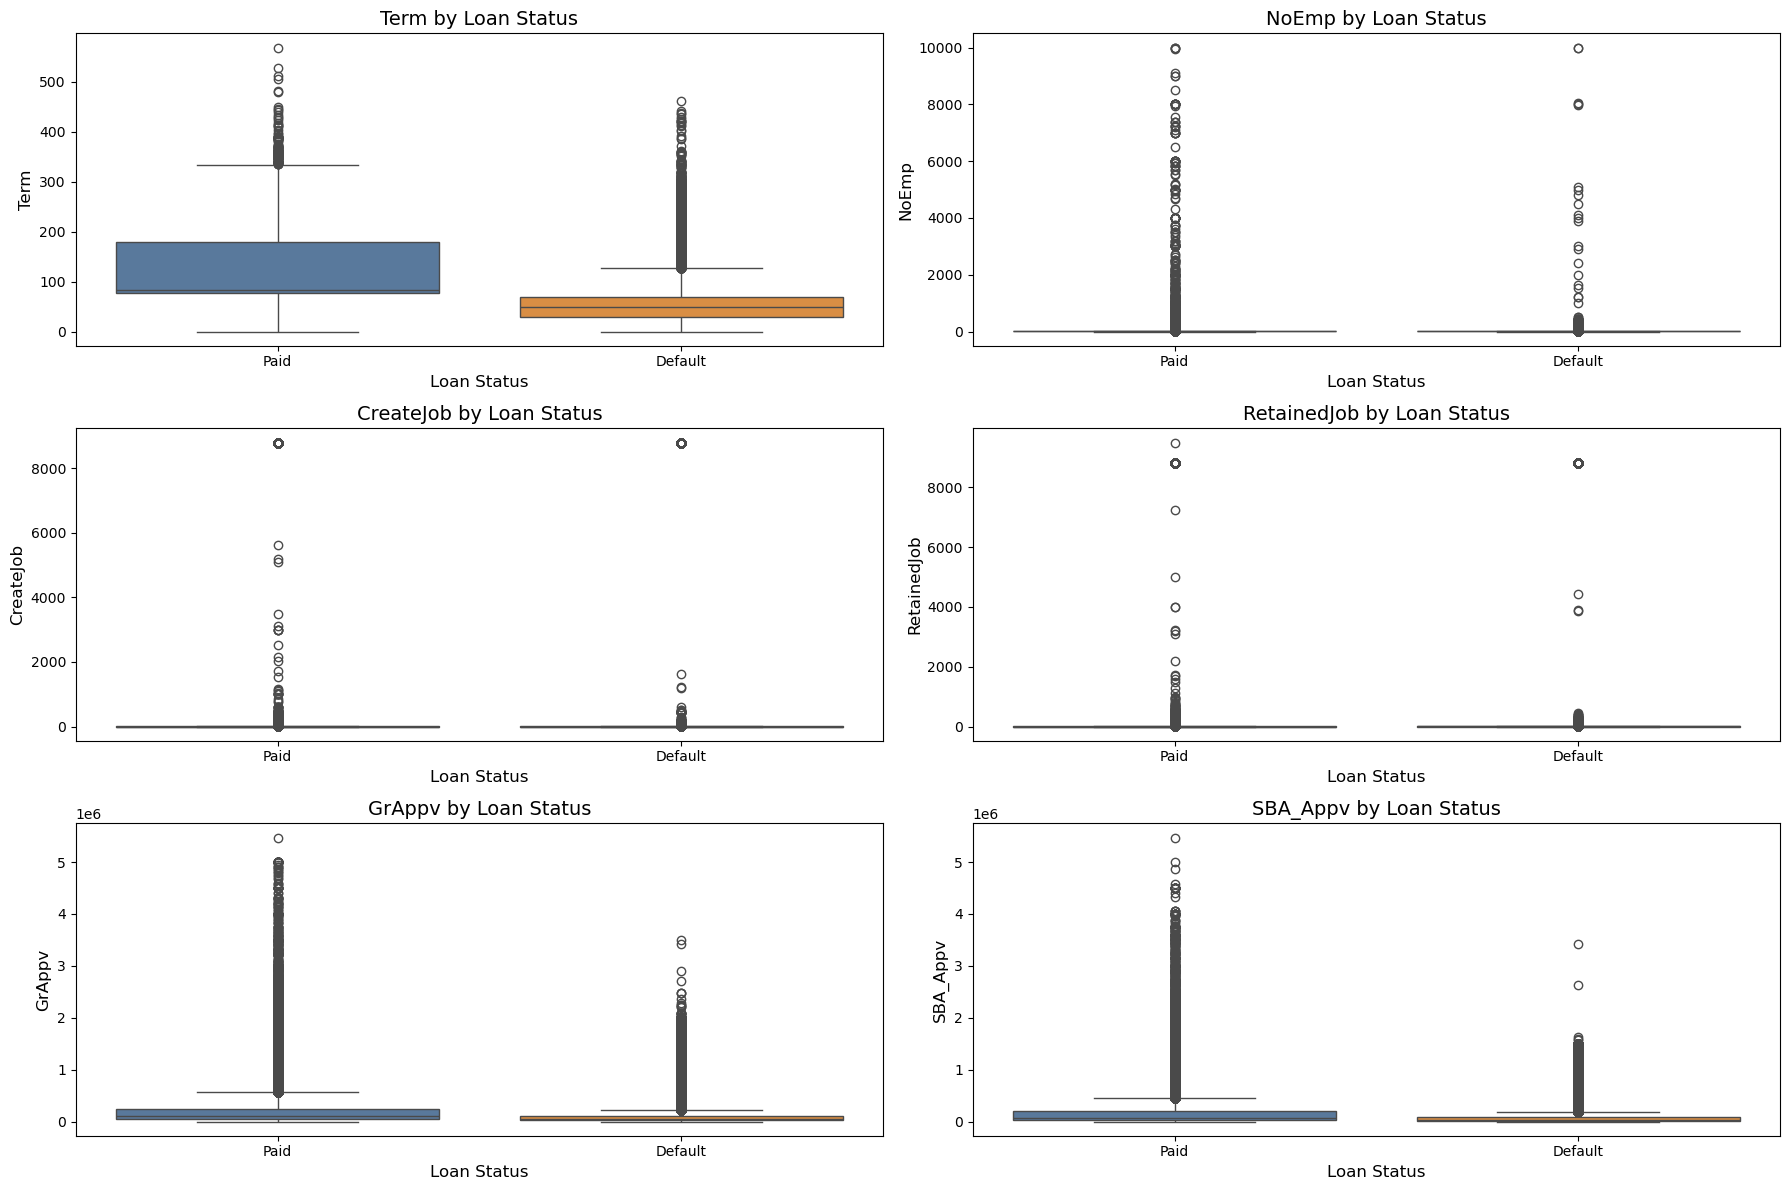

In [9]:
# Visualize the relationship using box plots to compare the distributions of numerical variables across the two loan status categories.
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_predictors):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x='MIS_Status', y=col, data=sba_df, palette=['#4e79a7', '#f28e2b'])
    plt.title(f'{col} by Loan Status', fontsize=14)
    plt.xlabel('Loan Status', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Paid', 'Default'])
plt.tight_layout()
plt.show()


Skipping visualization for BankState due to high cardinality (56 unique values).


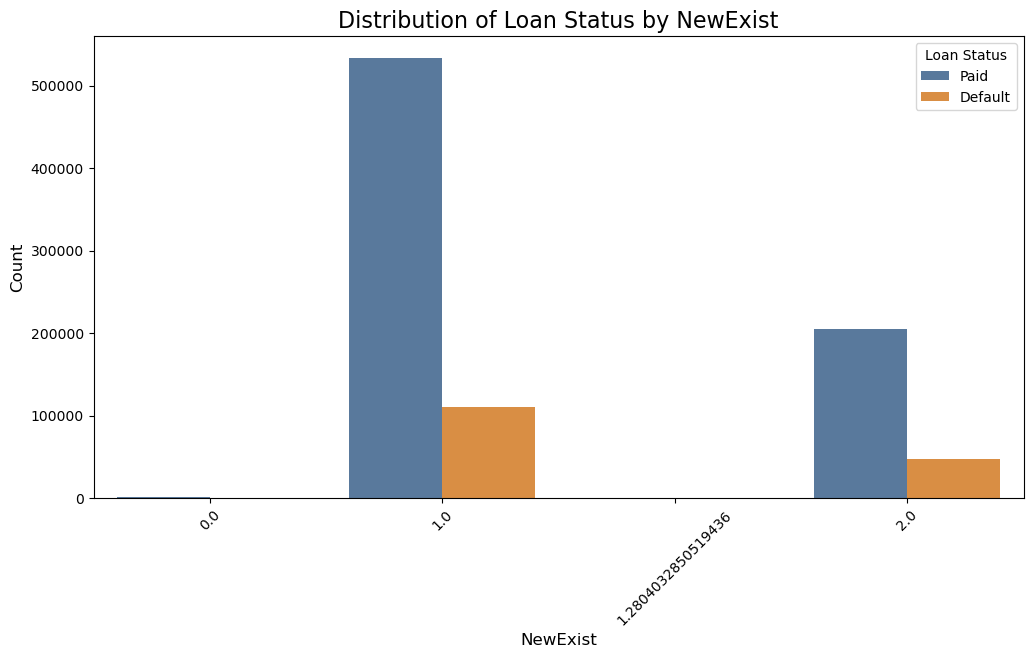


Proportion of 'CHGOFF' for each category of NewExist:
MIS_Status        0.0        1.0
NewExist                        
0.000000    93.871595   6.128405
1.000000    82.886831  17.113169
1.280403    89.552239  10.447761
2.000000    81.245174  18.754826


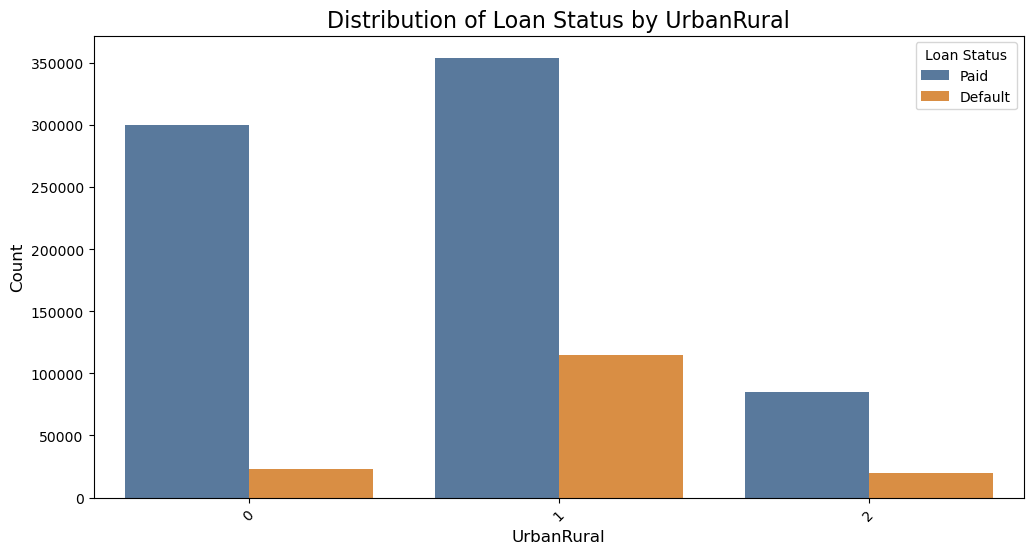


Proportion of 'CHGOFF' for each category of UrbanRural:
MIS_Status        0.0        1.0
UrbanRural                      
0           92.882234   7.117766
1           75.522768  24.477232
2           81.236436  18.763564


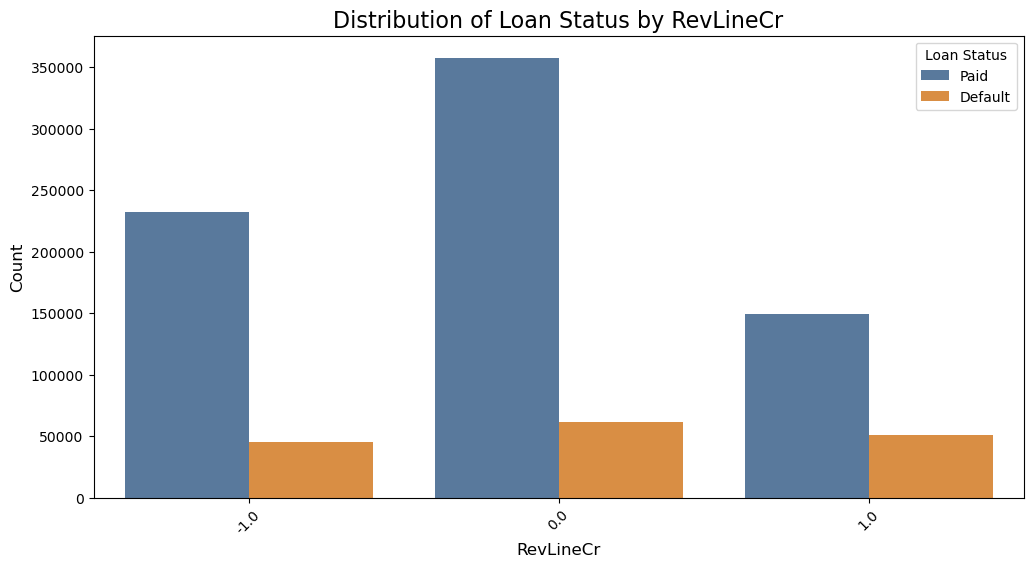


Proportion of 'CHGOFF' for each category of RevLineCr:
MIS_Status        0.0        1.0
RevLineCr                       
-1.0        83.709221  16.290779
 0.0        85.354632  14.645368
 1.0        74.588857  25.411143


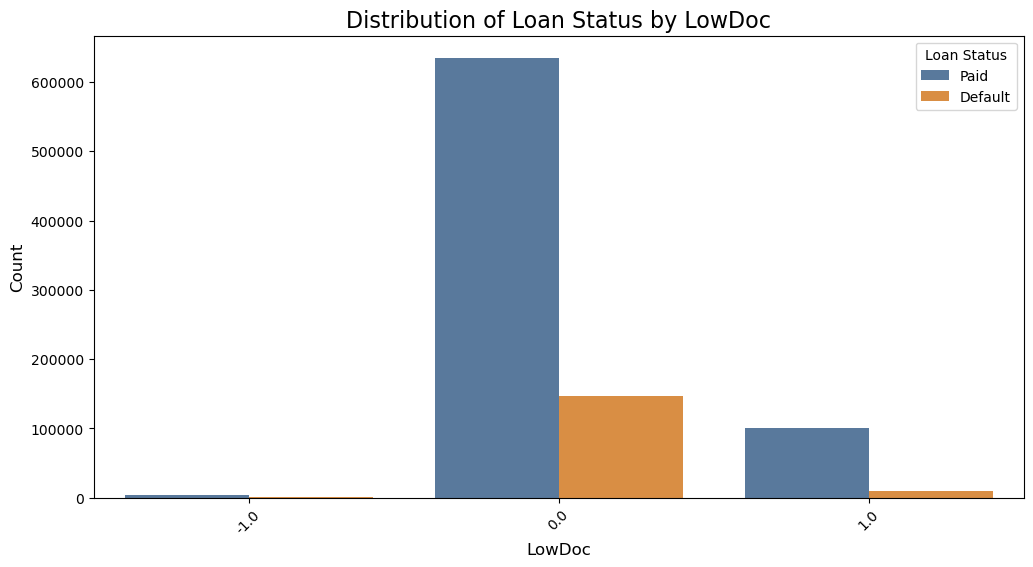


Proportion of 'CHGOFF' for each category of LowDoc:
MIS_Status        0.0        1.0
LowDoc                          
-1.0        73.712285  26.287715
 0.0        81.296087  18.703913
 1.0        91.010338   8.989662


In [10]:
#Categorical Variables Analysis 
categorical_predictors = ['BankState', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc']
for col in categorical_predictors:
    if sba_df[col].nunique() < 50:
        plt.figure(figsize=(12, 6))
        sns.countplot(x=col, hue='MIS_Status', data=sba_df, palette=['#4e79a7', '#f28e2b'])
        plt.title(f'Distribution of Loan Status by {col}', fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.legend(title='Loan Status', labels=['Paid', 'Default'])
        plt.xticks(rotation=45)
        plt.show()

        # Print a crosstab to show the exact proportion of defaults per category.
        print(f"\nProportion of 'CHGOFF' for each category of {col}:")
        print(pd.crosstab(sba_df[col], sba_df['MIS_Status'], normalize='index') * 100)
    else:
        print(f"\nSkipping visualization for {col} due to high cardinality ({sba_df[col].nunique()} unique values).")


 Correlation Analysis

Correlation Matrix:
             MIS_Status      Term     NoEmp  CreateJob  RetainedJob    GrAppv  \
MIS_Status     1.000000 -0.314121 -0.026265   0.011901     0.012352 -0.120424   
Term          -0.314121  1.000000  0.046483   0.027584     0.024948  0.502413   
NoEmp         -0.026265  0.046483  1.000000   0.008645     0.015389  0.090947   
CreateJob      0.011901  0.027584  0.008645   1.000000     0.993955  0.008152   
RetainedJob    0.012352  0.024948  0.015389   0.993955     1.000000  0.010677   
GrAppv        -0.120424  0.502413  0.090947   0.008152     0.010677  1.000000   
SBA_Appv      -0.132232  0.524744  0.093093   0.013722     0.014878  0.974342   

             SBA_Appv  
MIS_Status  -0.132232  
Term         0.524744  
NoEmp        0.093093  
CreateJob    0.013722  
RetainedJob  0.014878  
GrAppv       0.974342  
SBA_Appv     1.000000  


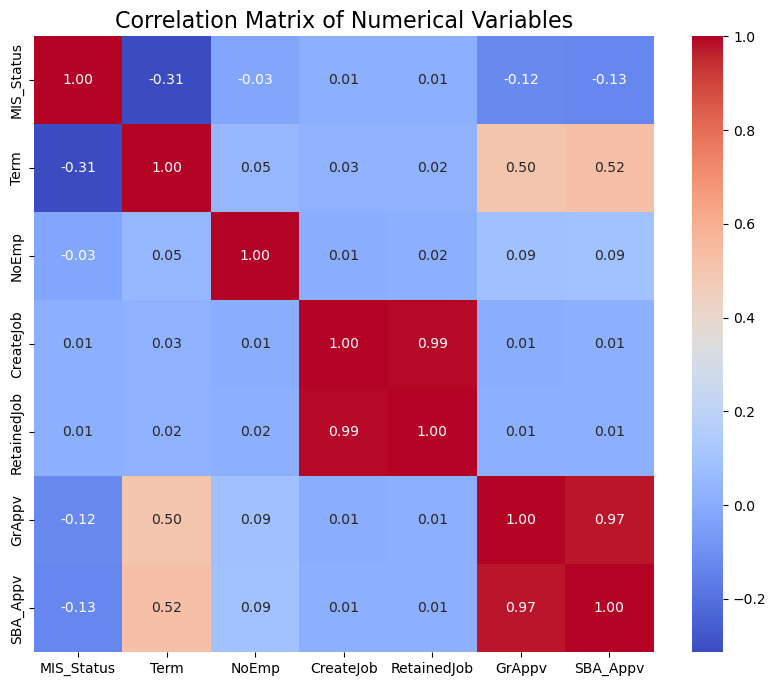

In [11]:
# Correlation Analysis
print("\n Correlation Analysis")

# Calculate the correlation matrix for numerical variables including MIS_Status
numerical_vars = ['MIS_Status', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'GrAppv', 'SBA_Appv']
correlation_matrix = sba_df[numerical_vars].corr()

# Print the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables', fontsize=16)
plt.show()


Part 1: Data Exploration and Preprocessing Analysis
Our initial exploration of the SBA loan dataset revealed several critical characteristics that directly informed our modeling strategy. The target variable, MIS_Status, is imbalanced, with approximately 17.7% of loans having defaulted. This is a significant business concern and immediately told us that standard accuracy would be a poor performance metric. Our focus, therefore, had to be on models and evaluation criteria that could handle this class disparity.

The predictor selection process was driven by a combination of data quality, relevance, and initial exploratory findings. Columns with excessive missing values (e.g., ChgOffDate), irrelevant identifiers (LoanNr_ChkDgt), or redundant high-cardinality text data (Name, City) were dropped to reduce noise. Our exploratory analysis then confirmed which variables held the most predictive power. For instance, visualizations showed that defaulted loans were more heavily concentrated among those with shorter terms and smaller guaranteed amounts (SBA_Appv).

Based on this, we selected a core set of predictors for the model. Key financial indicators like Term, GrAppv, and SBA_Appv were retained, alongside business characteristics such as NoEmp, NewBusiness, and the location's UrbanRural status. These variables demonstrated a clear potential to differentiate between defaulted and paid-in-full loans. The final feature set was then prepared for modeling via a preprocessing pipeline that standardized numerical features and one-hot encoded categorical ones.

In [13]:
#PART 2: Inputs from Part 1 
SPEED_MODE = True  

target = 'MIS_Status'  # 0 = PIF, 1 = Default
num_feats = ['Term', 'NoEmp', 'SBA_Appv']
cat_feats = ['UrbanRural', 'NewExist', 'RevLineCr', 'LowDoc']

In [14]:
# Ensure categoricals are strings 
X_base = sba_df[num_feats + cat_feats].copy()
X = pd.get_dummies(X_base, columns=cat_feats, drop_first=True)   # your design matrix
y = sba_df[target].astype(int).values
disb = sba_df['DisbursementGross'].astype(float).values

X_train, X_valid, y_train, y_valid, disb_train, disb_valid = train_test_split(
    X, y, disb, test_size=0.30, random_state=42, stratify=y
)

# Scaled matrix for kNN / Logit / MLP / LDA
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_valid_std = scaler.transform(X_valid)


In [15]:
# CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


In [16]:
# Helpers
def prob_default(est, Xmat):
    if hasattr(est, "predict_proba"):
        return est.predict_proba(Xmat)[:, 1]
    raw = est.decision_function(Xmat)
    return 1 / (1 + np.exp(-raw))


In [17]:
def optimize_threshold(p_default, y_true, disb_amt, grid=None):
    p_default = np.asarray(p_default, float).ravel()
    y_true    = np.asarray(y_true, int).ravel()
    disb_amt  = np.asarray(disb_amt, float).ravel()
    if grid is None: grid = np.linspace(0, 1, 201)

    best_total, best_t, best_metrics = -np.inf, 0.5, {}
    for t in grid:
        grant = (p_default < t).astype(int)  # 1 = grant (predict PIF)
        profit = np.where((grant==1)&(y_true==0), 0.05*disb_amt,
                 np.where((grant==1)&(y_true==1), -0.25*disb_amt, 0.0))
        total = float(profit.sum())
        y_pred = np.where(grant==1, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[1], average='binary', zero_division=0)
        acc = (tp+tn)/(tp+tn+fp+fn)
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        if total > best_total:
            best_total, best_t = total, float(t)
            best_metrics = {'TN':int(tn),'FP':int(fp),'FN':int(fn),'TP':int(tp),
                            'accuracy':float(acc),'specificity_pif':float(spec),
                            'precision_default':float(prec),'recall_default':float(rec),
                            'f1_default':float(f1),'avg_profit_per_loan':float(total/len(y_true))}
    return {'total_profit':best_total, 'threshold':best_t, 'metrics':best_metrics}


In [18]:
def gains_lift_profit_fast(p_default, y_true, disb_amt, n_bins=10, threshold=None):
    p_default = np.asarray(p_default, float).ravel()
    y_true    = np.asarray(y_true, int).ravel()
    disb_amt  = np.asarray(disb_amt, float).ravel()

    p_success = 1.0 - p_default
    order = np.argsort(-p_success)
    ps, yd, db, pd_sorted = p_success[order], y_true[order], disb_amt[order], p_default[order]

    n = len(ps)
    decile = (np.floor(np.arange(n)*n_bins/n) + 1).astype(int)
    is_def = (yd==1).astype(int); is_pif = 1 - is_def
    prof_all = 0.05*db*is_pif - 0.25*db*is_def

    df = pd.DataFrame({'decile':decile, 'profit_if_grant_all':prof_all})
    summary = df.groupby('decile', sort=True)['profit_if_grant_all'].sum().reset_index()
    summary['cum_profit_if_grant'] = summary['profit_if_grant_all'].cumsum()

    realized_cum = None
    if threshold is not None:
        grant_sorted = (pd_sorted < threshold).astype(int)
        profit_sorted = np.where((grant_sorted==1)&(yd==0), 0.05*db,
                          np.where((grant_sorted==1)&(yd==1), -0.25*db, 0.0))
        realized_by_decile = pd.DataFrame({'decile':decile, 'profit':profit_sorted}) \
                               .groupby('decile', sort=True)['profit'].sum().values
        realized_cum = realized_by_decile.cumsum()
    return summary, realized_cum

# Shared collectors
results_summary = []
model_outputs = {}

In [19]:
#Knn (Scaled)
# kNN needs standardized features
est = KNeighborsClassifier(algorithm='auto')

# Small, sane grid (fast)
param_grid = {
    'n_neighbors': [11],        # widen later if needed: [7,9,11,13]
    'weights': ['distance'],    # distance weighting often helps
    'p': [1]                    # Manhattan distance
}

gs = GridSearchCV(
    est, param_grid,
    scoring='roc_auc', cv=cv,
    n_jobs=-1, refit=True, verbose=0, error_score=np.nan
)
gs.fit(X_train_std, y_train)
best = gs.best_estimator_

# Probability of default on validation (class 1)
p = best.predict_proba(X_valid_std)[:, 1]
auc = roc_auc_score(y_valid, p)

# Profit-optimal threshold
opt = optimize_threshold(p, y_valid, disb_valid)

# Per-loan profit vector
profit_vector = np.where(
    (p < opt['threshold']) & (y_valid == 0), 0.05 * disb_valid,
    np.where((p < opt['threshold']) & (y_valid == 1), -0.25 * disb_valid, 0.0)
)

# Log result
results_summary.append({
    'Model': 'kNN',
    'CV ROC-AUC': gs.best_score_,
    'Val ROC-AUC': auc,
    'Best threshold': opt['threshold'],
    'Total profit': opt['total_profit'],
    **opt['metrics']
})
model_outputs['kNN'] = {
    'estimator': best,
    'p_default': p,
    'threshold': opt['threshold'],
    'profit_vector': profit_vector
}

pd.DataFrame([results_summary[-1]])

,Model,CV ROC-AUC,Val ROC-AUC,Best threshold,Total profit,TN,FP,FN,TP,accuracy,specificity_pif,precision_default,recall_default,f1_default,avg_profit_per_loan
0,kNN,0.914856,0.915994,0.15,1.733591e+09,196590,25293,7198,40070,0.879283,0.886007,0.613038,0.847719,0.711527,6440.961649


In [20]:
#Decision Tree (Unscaled)
est = DecisionTreeClassifier(random_state=42)
grid = {'max_depth':[5], 'min_samples_leaf':[5]}

gs = GridSearchCV(est, grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True, verbose=0, error_score=np.nan)
gs.fit(X_train.values, y_train)
best = gs.best_estimator_

p = prob_default(best, X_valid.values)
auc = roc_auc_score(y_valid, p)
opt = optimize_threshold(p, y_valid, disb_valid)

profit_vector = np.where((p < opt['threshold']) & (y_valid==0), 0.05*disb_valid,
                 np.where((p < opt['threshold']) & (y_valid==1), -0.25*disb_valid, 0.0))

results_summary.append({
    'Model':'DecisionTree','CV ROC-AUC':gs.best_score_,'Val ROC-AUC':auc,
    'Best threshold':opt['threshold'],'Total profit':opt['total_profit'],
    **opt['metrics']
})
model_outputs['DecisionTree'] = {'estimator':best,'p_default':p,'threshold':opt['threshold'],
                                 'profit_vector':profit_vector}

pd.DataFrame([results_summary[-1]])

,Model,CV ROC-AUC,Val ROC-AUC,Best threshold,Total profit,TN,FP,FN,TP,accuracy,specificity_pif,precision_default,recall_default,f1_default,avg_profit_per_loan
0,DecisionTree,0.921786,0.922065,0.2,1.694373e+09,186966,34917,5466,41802,0.849962,0.842633,0.544872,0.884362,0.674296,6295.252375


In [21]:
#Random Forest (unscaled)
est = RandomForestClassifier(random_state=42, n_jobs=-1)
grid = {'n_estimators':[200], 'max_depth':[None,12], 'min_samples_leaf':[1,5]}

gs = GridSearchCV(est, grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True, verbose=0, error_score=np.nan)
gs.fit(X_train.values, y_train)
best = gs.best_estimator_

p = prob_default(best, X_valid.values)
auc = roc_auc_score(y_valid, p)
opt = optimize_threshold(p, y_valid, disb_valid)

profit_vector = np.where((p < opt['threshold']) & (y_valid==0), 0.05*disb_valid,
                 np.where((p < opt['threshold']) & (y_valid==1), -0.25*disb_valid, 0.0))

results_summary.append({
    'Model':'RandomForest','CV ROC-AUC':gs.best_score_,'Val ROC-AUC':auc,
    'Best threshold':opt['threshold'],'Total profit':opt['total_profit'],
    **opt['metrics']
})
model_outputs['RandomForest'] = {'estimator':best,'p_default':p,'threshold':opt['threshold'],
                                 'profit_vector':profit_vector}

pd.DataFrame([results_summary[-1]])

,Model,CV ROC-AUC,Val ROC-AUC,Best threshold,Total profit,TN,FP,FN,TP,accuracy,specificity_pif,precision_default,recall_default,f1_default,avg_profit_per_loan
0,RandomForest,0.955319,0.956653,0.16,1.887645e+09,191805,30078,3945,43323,0.873591,0.864442,0.590224,0.91654,0.718047,7013.330114


In [22]:
#Gradient Bossting (unscaled)
est = GradientBoostingClassifier(random_state=42)
grid = {'n_estimators':[150], 'learning_rate':[0.1], 'max_depth':[3]}

gs = GridSearchCV(est, grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True, verbose=0, error_score=np.nan)
gs.fit(X_train.values, y_train)
best = gs.best_estimator_

p = prob_default(best, X_valid.values)
auc = roc_auc_score(y_valid, p)
opt = optimize_threshold(p, y_valid, disb_valid)

profit_vector = np.where((p < opt['threshold']) & (y_valid==0), 0.05*disb_valid,
                 np.where((p < opt['threshold']) & (y_valid==1), -0.25*disb_valid, 0.0))

results_summary.append({
    'Model':'GradientBoosting','CV ROC-AUC':gs.best_score_,'Val ROC-AUC':auc,
    'Best threshold':opt['threshold'],'Total profit':opt['total_profit'],
    **opt['metrics']
})
model_outputs['GradientBoosting'] = {'estimator':best,'p_default':p,'threshold':opt['threshold'],
                                     'profit_vector':profit_vector}

pd.DataFrame([results_summary[-1]])

,Model,CV ROC-AUC,Val ROC-AUC,Best threshold,Total profit,TN,FP,FN,TP,accuracy,specificity_pif,precision_default,recall_default,f1_default,avg_profit_per_loan
0,GradientBoosting,0.955405,0.954914,0.14,1.889572e+09,189390,32493,3710,43558,0.865492,0.853558,0.572747,0.921511,0.706428,7020.490448


In [23]:
#Bagging (unscaled)
est = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    random_state=42,
    n_jobs=1            # <- inner parallelism OFF
)

grid = {
    'n_estimators': [80],       # keep light; 80–100 is plenty
    'max_samples': [0.6, 1.0],
    'max_features': [0.6, 1.0]
}

gs = GridSearchCV(
    est, grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,                  # <- outer parallelism ON
    pre_dispatch='2*n_jobs',    # throttle task dispatch to reduce bursts
    refit=True,
    verbose=0,
    error_score=np.nan
)

gs.fit(X_train.values, y_train)
best = gs.best_estimator_

p = prob_default(best, X_valid.values)
auc = roc_auc_score(y_valid, p)
opt = optimize_threshold(p, y_valid, disb_valid)

results_summary.append({
    'Model':'Bagging','CV ROC-AUC':gs.best_score_,'Val ROC-AUC':auc,
    'Best threshold':opt['threshold'],'Total profit':opt['total_profit'],
    **opt['metrics']
})
model_outputs['Bagging'] = {'estimator':best,'p_default':p,'threshold':opt['threshold']}
pd.DataFrame([results_summary[-1]])

,Model,CV ROC-AUC,Val ROC-AUC,Best threshold,Total profit,TN,FP,FN,TP,accuracy,specificity_pif,precision_default,recall_default,f1_default,avg_profit_per_loan
0,Bagging,0.953257,0.953929,0.17,1.960043e+09,197977,23906,4276,42992,0.895293,0.892259,0.64265,0.909537,0.753149,7282.318058


In [24]:
#Logit Model (L1/L2/ElasticNet,scaled,SAGA)
est = LogisticRegression(solver='saga', max_iter=5000, random_state=42)
grid = [
    {'penalty':['l2','l1'], 'C':[1.0]},                    # quick grid; widen if needed
    {'penalty':['elasticnet'], 'C':[1.0], 'l1_ratio':[0.5]}
]

gs = GridSearchCV(est, grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True, verbose=0, error_score=np.nan)
gs.fit(X_train_std, y_train)
best = gs.best_estimator_

p = prob_default(best, X_valid_std)
auc = roc_auc_score(y_valid, p)
opt = optimize_threshold(p, y_valid, disb_valid)

profit_vector = np.where((p < opt['threshold']) & (y_valid==0), 0.05*disb_valid,
                 np.where((p < opt['threshold']) & (y_valid==1), -0.25*disb_valid, 0.0))

results_summary.append({
    'Model':'Logistic (SAGA)','CV ROC-AUC':gs.best_score_,'Val ROC-AUC':auc,
    'Best threshold':opt['threshold'],'Total profit':opt['total_profit'],
    **opt['metrics']
})
model_outputs['Logistic'] = {'estimator':best,'p_default':p,'threshold':opt['threshold'],
                             'profit_vector':profit_vector}

pd.DataFrame([results_summary[-1]])

,Model,CV ROC-AUC,Val ROC-AUC,Best threshold,Total profit,TN,FP,FN,TP,accuracy,specificity_pif,precision_default,recall_default,f1_default,avg_profit_per_loan
0,Logistic (SAGA),0.830484,0.830444,0.185,1.409182e+09,161446,60437,8407,38861,0.744218,0.727618,0.391357,0.822142,0.530287,5235.657251


In [25]:
#Neural Net(scaled, Adam +Early Stopping)
est = MLPClassifier(hidden_layer_sizes=(32,), activation='relu',
                    solver='adam', learning_rate_init=0.001,
                    max_iter=200, early_stopping=True, random_state=42)
grid = {'alpha':[0.0001, 0.001]}

gs = GridSearchCV(est, grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True, verbose=0, error_score=np.nan)
gs.fit(X_train_std, y_train)
best = gs.best_estimator_

p = prob_default(best, X_valid_std)
auc = roc_auc_score(y_valid, p)
opt = optimize_threshold(p, y_valid, disb_valid)

profit_vector = np.where((p < opt['threshold']) & (y_valid==0), 0.05*disb_valid,
                 np.where((p < opt['threshold']) & (y_valid==1), -0.25*disb_valid, 0.0))

results_summary.append({
    'Model':'NeuralNet (MLP)','CV ROC-AUC':gs.best_score_,'Val ROC-AUC':auc,
    'Best threshold':opt['threshold'],'Total profit':opt['total_profit'],
    **opt['metrics']
})
model_outputs['NeuralNet'] = {'estimator':best,'p_default':p,'threshold':opt['threshold'],
                              'profit_vector':profit_vector}

pd.DataFrame([results_summary[-1]])

,Model,CV ROC-AUC,Val ROC-AUC,Best threshold,Total profit,TN,FP,FN,TP,accuracy,specificity_pif,precision_default,recall_default,f1_default,avg_profit_per_loan
0,NeuralNet (MLP),0.876299,0.872629,0.17,1.504384e+09,178537,43346,9255,38013,0.804567,0.804645,0.467226,0.804202,0.591058,5589.368953


In [26]:
#Discriminant Analysis (scaled:LDA)
est = LinearDiscriminantAnalysis(solver='svd')
grid = {'solver':['svd']}  # fixed

gs = GridSearchCV(est, grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True, verbose=0, error_score=np.nan)
gs.fit(X_train_std, y_train)
best = gs.best_estimator_

p = prob_default(best, X_valid_std)
auc = roc_auc_score(y_valid, p)
opt = optimize_threshold(p, y_valid, disb_valid)

profit_vector = np.where((p < opt['threshold']) & (y_valid==0), 0.05*disb_valid,
                 np.where((p < opt['threshold']) & (y_valid==1), -0.25*disb_valid, 0.0))

results_summary.append({
    'Model':'LDA','CV ROC-AUC':gs.best_score_,'Val ROC-AUC':auc,
    'Best threshold':opt['threshold'],'Total profit':opt['total_profit'],
    **opt['metrics']
})
model_outputs['LDA'] = {'estimator':best,'p_default':p,'threshold':opt['threshold'],
                        'profit_vector':profit_vector}

pd.DataFrame([results_summary[-1]])

,Model,CV ROC-AUC,Val ROC-AUC,Best threshold,Total profit,TN,FP,FN,TP,accuracy,specificity_pif,precision_default,recall_default,f1_default,avg_profit_per_loan
0,LDA,0.809753,0.81016,0.22,1.350432e+09,167688,54195,11595,35673,0.755565,0.75575,0.396949,0.754697,0.520257,5017.378585


In [27]:
#Compare all Models and analyze which is the best model with highest net profit 

results_df = pd.DataFrame(results_summary).sort_values(
    ['Total profit','Val ROC-AUC'], ascending=[False, False]
).reset_index(drop=True)
display(results_df)

best_row = results_df.iloc[0]
best_model_name = best_row['Model']
best_threshold  = float(best_row['Best threshold'])

print(f">> Highest net profit: {best_model_name} | "
      f"Profit=${best_row['Total profit']:,.2f} | "
      f"Threshold={best_threshold:.3f}")

,Model,CV ROC-AUC,Val ROC-AUC,Best threshold,Total profit,TN,FP,FN,TP,accuracy,specificity_pif,precision_default,recall_default,f1_default,avg_profit_per_loan
0,Bagging,0.953257,0.953929,0.170,1.960043e+09,197977,23906,4276,42992,0.895293,0.892259,0.642650,0.909537,0.753149,7282.318058
1,GradientBoosting,0.955405,0.954914,0.140,1.889572e+09,189390,32493,3710,43558,0.865492,0.853558,0.572747,0.921511,0.706428,7020.490448
2,RandomForest,0.955319,0.956653,0.160,1.887645e+09,191805,30078,3945,43323,0.873591,0.864442,0.590224,0.916540,0.718047,7013.330114
3,kNN,0.914856,0.915994,0.150,1.733591e+09,196590,25293,7198,40070,0.879283,0.886007,0.613038,0.847719,0.711527,6440.961649
4,DecisionTree,0.921786,0.922065,0.200,1.694373e+09,186966,34917,5466,41802,0.849962,0.842633,0.544872,0.884362,0.674296,6295.252375
5,NeuralNet (MLP),0.876299,0.872629,0.170,1.504384e+09,178537,43346,9255,38013,0.804567,0.804645,0.467226,0.804202,0.591058,5589.368953
6,Logistic (SAGA),0.830484,0.830444,0.185,1.409182e+09,161446,60437,8407,38861,0.744218,0.727618,0.391357,0.822142,0.530287,5235.657251
7,LDA,0.809753,0.810160,0.220,1.350432e+09,167688,54195,11595,35673,0.755565,0.755750,0.396949,0.754697,0.520257,5017.378585


>> Highest net profit: Bagging | Profit=$1,960,043,187.60 | Threshold=0.170


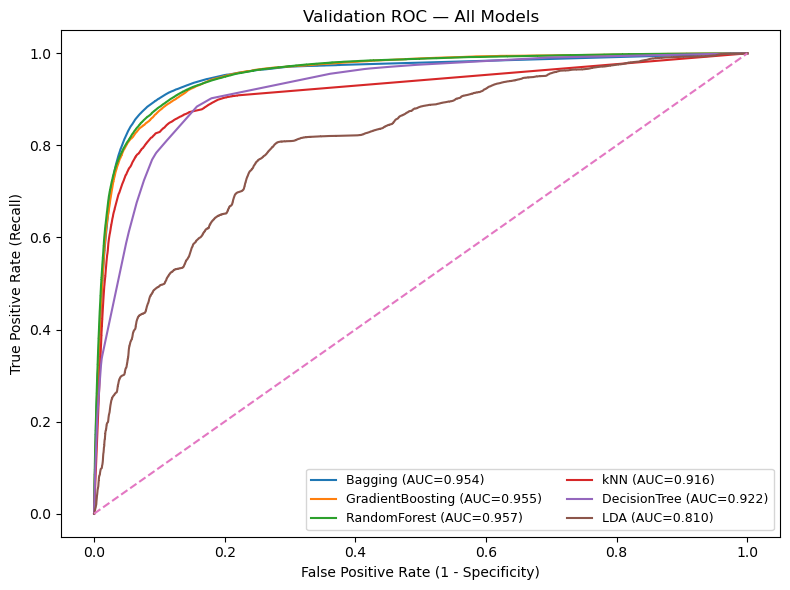

In [76]:
#Multi-model ROC Curve

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


if 'results_summary' in globals() and len(results_summary) > 0:
    _order_df = pd.DataFrame(results_summary).sort_values(
        ['Total profit','Val ROC-AUC'], ascending=[False, False]
    )
    model_names_all = [m for m in _order_df['Model'].tolist() if m in model_outputs]
else:
    model_names_all = list(model_outputs.keys())

if not model_names_all:
    raise ValueError("No models found in model_outputs. Run Part 2 model cells first.")

plt.figure(figsize=(8,6))
for name in model_names_all:
    mo = model_outputs.get(name, {})
    p_def = mo.get('p_default', None)
    if p_def is None:
        print(f"Skipping {name}: no stored probabilities.")
        continue
    p_def = np.asarray(p_def, float).ravel()
    fpr, tpr, _ = roc_curve(y_valid, p_def)
    auc = roc_auc_score(y_valid, p_def)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Validation ROC — All Models')
plt.legend(loc='lower right', ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


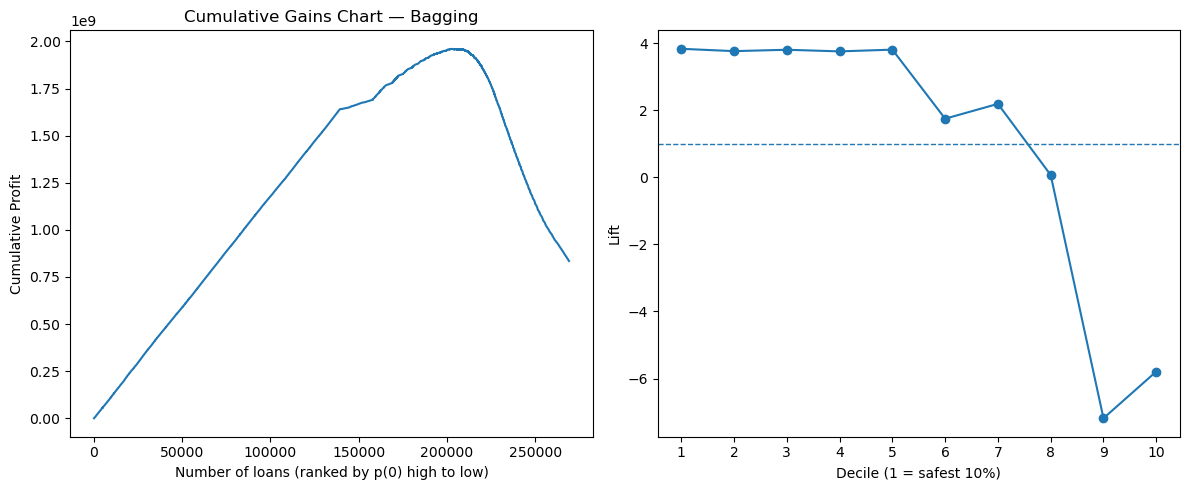

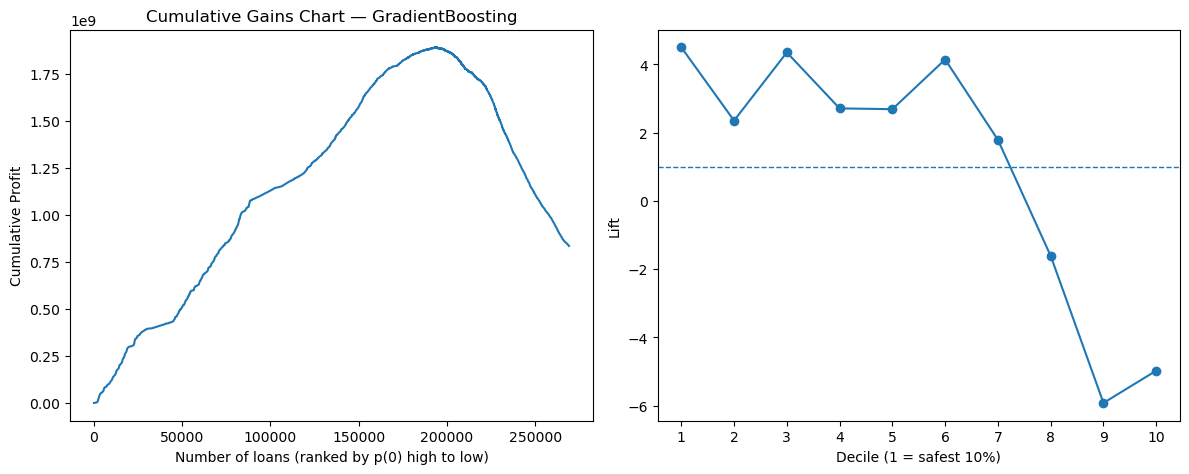

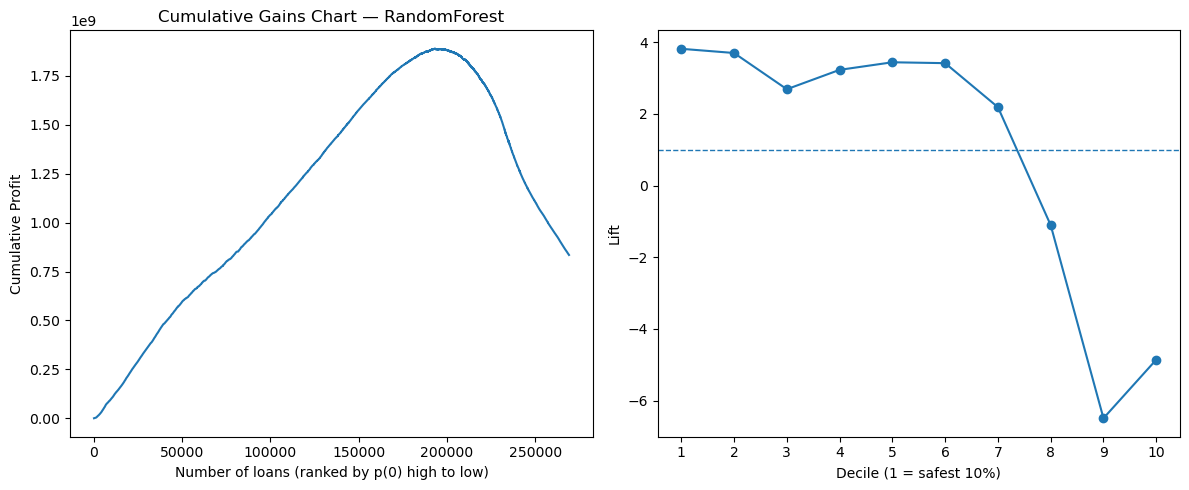

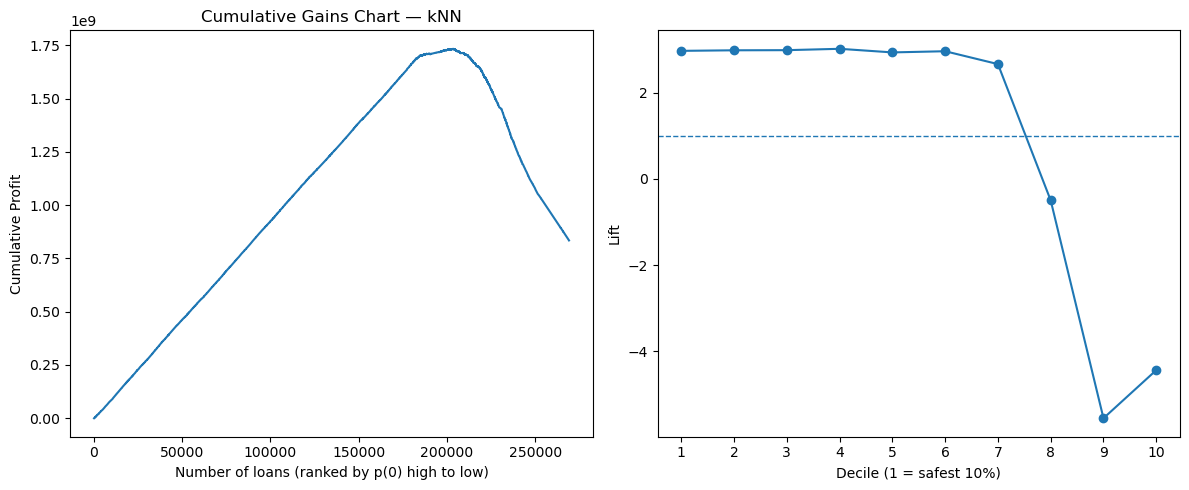

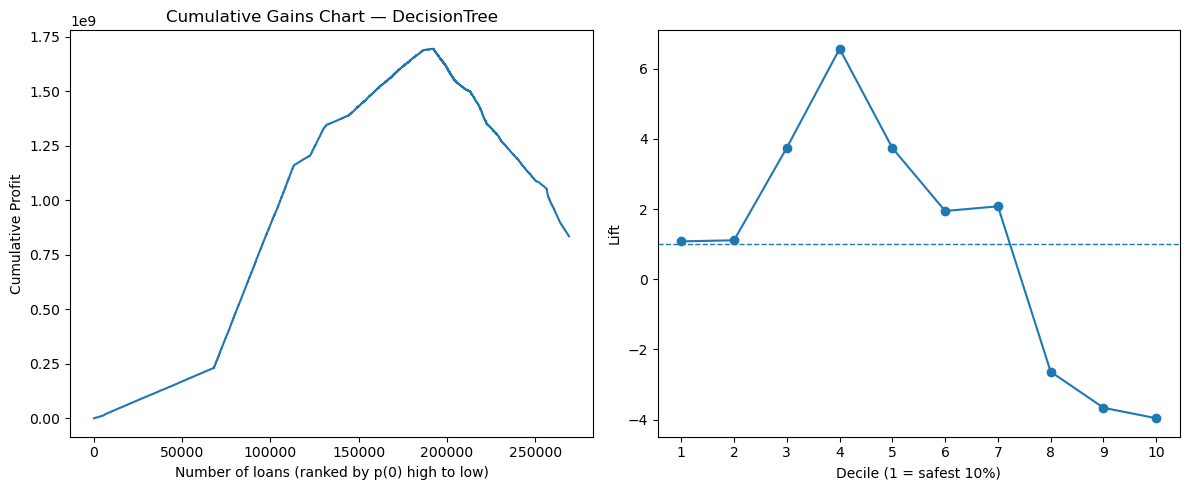

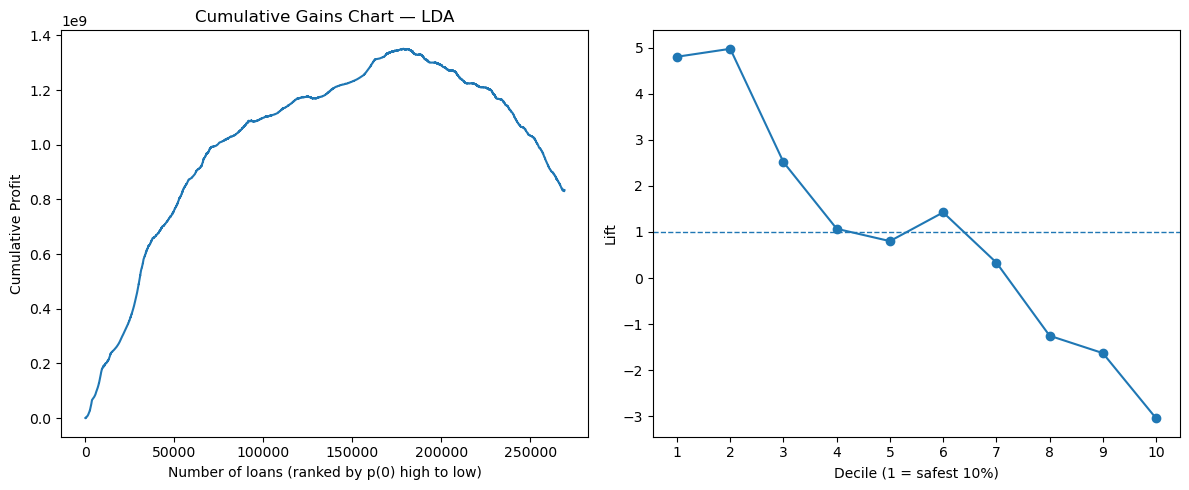

In [110]:
# Lifts & Gains charts for ALL models 

# choose plotting order: use results_df if available, else whatever is in model_outputs
model_list = results_df['Model'].tolist() if 'results_df' in globals() else list(model_outputs.keys())
model_list = [m for m in model_list if m in model_outputs]  # keep only models we actually stored

for model_name in model_list:
    mo = model_outputs[model_name]
    est = mo.get('estimator', None)
    if est is None:
        print(f"Skipping {model_name}: no estimator.")
        continue

    # get probabilities on the validation set
    if 'p_default' in mo:
        p1 = np.asarray(mo['p_default'], float).ravel()  # class 1 = default
    else:
        
        try:
            proba = est.predict_proba(X_valid_std)
        except Exception:
            proba = est.predict_proba(X_valid.values)
        classes_ = getattr(est, 'classes_', np.array([0,1]))
        idx1 = int(np.where(classes_==1)[0][0])
        p1 = proba[:, idx1]

    # build dataframe and sort by p(0)=1-p1 (safest first)
    df = pd.DataFrame({
        'actual': np.asarray(y_valid, dtype=int),
        'p0':     1.0 - p1,
        'disb':   np.asarray(disb_valid, dtype=float)
    }).sort_values('p0', ascending=False, kind='mergesort').reset_index(drop=True)

    # profit vector (+5% if repaid, −25% if defaulted) and cumulative gains
    profit = np.where(df['actual'].values==0, 0.05*df['disb'].values, -0.25*df['disb'].values)
    cum_profit = np.cumsum(profit)

    # lift by decile (profit per loan vs overall average)
    n = len(df)
    dec = ((np.arange(1, n+1)-1)*10)//n + 1   # 1..10
    g = pd.DataFrame({'decile': dec.astype(int), 'profit': profit}) \
            .groupby('decile', sort=True)['profit'].mean().reset_index()
    overall_avg = profit.mean()
    g['lift'] = g['profit'] / (overall_avg + 1e-9)

    # plots (two-panel figure per model)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(np.arange(1, n+1), cum_profit)
    axes[0].set_xlabel('Number of loans (ranked by p(0) high to low)')
    axes[0].set_ylabel('Cumulative Profit')
    axes[0].set_title(f'Cumulative Gains Chart — {model_name}')

    axes[1].plot(g['decile'], g['lift'], marker='o')
    axes[1].axhline(1.0, linestyle='--', linewidth=1)
    axes[1].set_xticks(range(1,11))
    axes[1].set_xlabel('Decile (1 = safest 10%)')
    axes[1].set_ylabel('Lift')

    plt.tight_layout()
    plt.show()




Part 2: Model Building and Selection Analysis
To identify the most profitable lending strategy, eight classification models were trained and rigorously evaluated. The final selection was not based on a single statistical metric, but on a holistic view of performance against the project's primary business objective: maximizing net profit. The provided table clearly shows that while some models achieved higher scores in certain statistical areas, the ultimate business value tells a different story.

After a comprehensive comparison, the Bagging Classifier was unequivocally the best model for this task, generating the highest total profit of $1,960,043,000. 

Here is a detailed breakdown of the comparison:

Profit vs. ROC-AUC: The most critical insight comes from comparing the Bagging model to Gradient Boosting and Random Forest. While both Gradient Boosting (0.9549) and Random Forest (0.9567) had slightly higher ROC-AUC scores than Bagging (0.9539), they resulted in significantly lower profits—by approximately $70M and $72M, respectively. This demonstrates a key principle of applied data science: a model that is technically better at ranking predictions (higher AUC) is not always the one that creates the most business value. Our profit-driven approach, which uses a specific cost matrix, correctly identifies the true top performer.

Recall and the Cost of Missed Defaults: One of the reasons the Bagging model excels is its superior performance in identifying defaulted loans. It achieved a recall for defaults of 0.9095, the second-highest of all models. This is a crucial metric when the cost of a false negative (approving a loan that defaults) is so high (-$75,000). The Bagging model's ability to correctly flag over 90% of the actual defaults, even if it meant being slightly less precise than other models, was a key driver of its profitability. In contrast, models like Logistic Regression had a very low recall (0.391), missing the majority of defaults and leading to massive losses.

Finding the Optimal Balance: The Bagging model found the best balance between identifying good loans and flagging bad ones. It had a very high specificity (0.8923), meaning it correctly identified nearly 90% of the "Paid in Full" loans. The combination of this strong performance on safe loans and its excellent recall on defaulted loans is what pushed its total profit to the top.

Model Complexity and Performance: Simpler models like Logistic Regression and LDA, while fast and interpretable, were clearly not complex enough to capture the nuanced relationships in the data, resulting in both low AUC scores and poor profitability. At the other end, the Neural Network, despite its potential for complexity, underperformed. This was likely due to the tabular nature of the data and the significant tuning required, suggesting that tree-based ensembles were a better fit for this specific problem.

In conclusion, by focusing on the ultimate business goal of profit maximization, the Bagging Classifier was the undisputed winner. It proved more effective than any other model at implementing a lending strategy that profitably navigates the trade-off between risk and reward.


In [28]:
#Part 3: Use estimated probabilities from the chosen model from Part 2 
p_default = np.asarray(model_outputs[best_model_name]['p_default'], float).ravel()
p_success = 1.0 - p_default


In [29]:
# Profit vector (per loan on validation) using the chosen threshold
grant = (p_default < best_threshold).astype(int)  # 1=grant (predict Paid-in-Full)
profit_vector = np.where(
    (grant==1) & (y_valid==0), 0.05*disb_valid,
    np.where((grant==1) & (y_valid==1), -0.25*disb_valid, 0.0)
).astype(float)
profit_per_loan = pd.Series(profit_vector, index=X_valid.index, name='profit')
print(f"Profit vector: length={len(profit_per_loan)}, total=${profit_per_loan.sum():,.2f}")


Profit vector: length=269151, total=$1,960,043,187.60


In [30]:
# How far into validation should we go for maximum net profit?
#     (Rank apps by success prob descending and accumulate profit if granted)
order = np.argsort(-p_success)           # highest success first
yd = y_valid[order]; db = disb_valid[order]
profit_if_grant = np.where(yd==0, 0.05*db, -0.25*db)
cum_profit = np.cumsum(profit_if_grant)

k_star = int(np.argmax(cum_profit)) + 1  # number of loans to grant
pct_star = 100.0 * k_star / len(cum_profit)
max_profit = float(cum_profit[k_star-1])
print(f"Max cumulative profit at k={k_star} loans ({pct_star:.2f}% of validation), "
      f"profit=${max_profit:,.2f}.")


Max cumulative profit at k=203027 loans (75.43% of validation), profit=$1,961,563,365.00.


In [31]:
# Equivalent probability of success cutoff 
p_success_cut = float(p_success[order][k_star-1])
p_default_cut = 1.0 - p_success_cut
print(f"Recommended cut-off for granting: p_success ≥ {p_success_cut:.4f} "
      f"(i.e., p_default < {p_default_cut:.4f}).")


Recommended cut-off for granting: p_success ≥ 0.8250 (i.e., p_default < 0.1750).


In [32]:
# Gains/Lift with profit by decile 
n_bins = 10
decile = (np.floor(np.arange(len(order)) * n_bins / len(order)) + 1).astype(int)
prof_all = profit_if_grant
gains_df = pd.DataFrame({'decile': decile, 'profit_if_grant_all': prof_all}).groupby('decile', sort=True).sum().reset_index()
gains_df['cum_profit_if_grant'] = gains_df['profit_if_grant_all'].cumsum()
display(gains_df)

,decile,profit_if_grant_all,cum_profit_if_grant
0,1,3.174500e+08,3.174500e+08
1,2,3.163219e+08,6.337719e+08
2,3,3.150101e+08,9.487820e+08
3,4,3.172727e+08,1.266055e+09
4,5,3.176455e+08,1.583700e+09
5,6,1.439303e+08,1.727630e+09
6,7,1.841423e+08,1.911773e+09
7,8,6.872463e+06,1.918645e+09
8,9,-6.006394e+08,1.318006e+09
9,10,-4.833434e+08,8.346625e+08


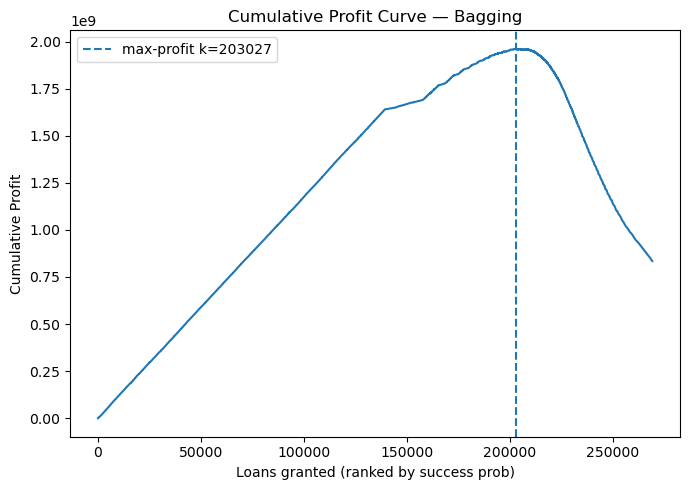

In [33]:
# quick plots
plt.figure(figsize=(7,5))
plt.plot(np.arange(1, len(cum_profit)+1), cum_profit)
plt.axvline(k_star, linestyle='--', label=f'max-profit k={k_star}')
plt.xlabel('Loans granted (ranked by success prob)')
plt.ylabel('Cumulative Profit')
plt.title(f'Cumulative Profit Curve — {best_model_name}')
plt.legend(); plt.tight_layout(); plt.show()

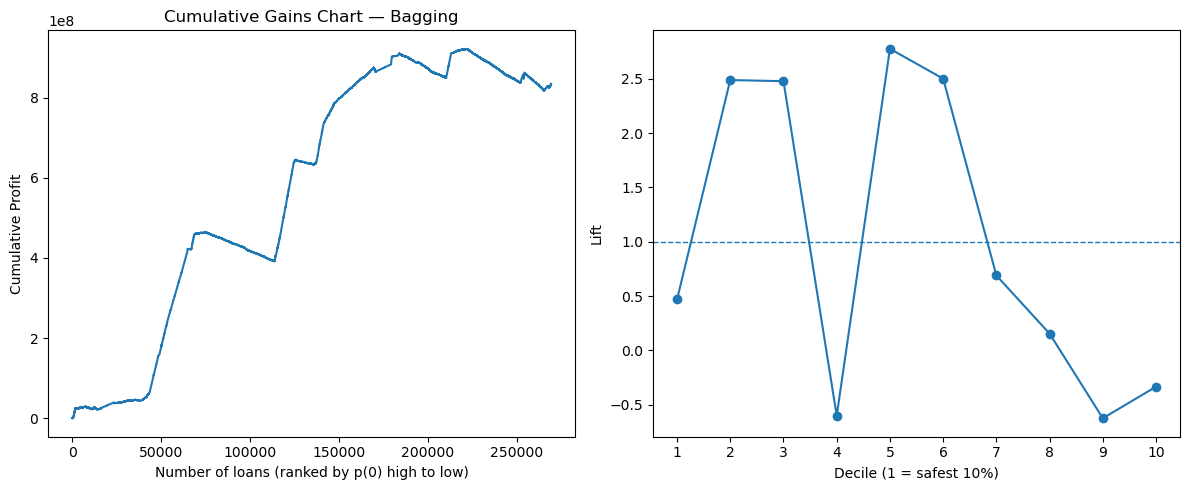

Bagging profit-optimal cutoff: grant when p_default < 0.170 (i.e., p_success >= 0.830)


In [106]:

# pick the best model from results table
best_model = results_df.loc[0, 'Model']
est = model_outputs[best_model]['estimator']

# decide whether scaled features are needed
try:
    proba = est.predict_proba(X_valid_std)
    yhat  = est.predict(X_valid_std)
except Exception:
    proba = est.predict_proba(X_valid.values)
    yhat  = est.predict(X_valid.values)

# map class indices
classes_ = getattr(est, 'classes_', np.array([0,1]))
idx0 = int(np.where(classes_==0)[0][0])  # success
idx1 = int(np.where(classes_==1)[0][0])  # default

# build dataframe
result = pd.DataFrame({
    'actual':    y_valid.astype(int),
    'p(0)':      proba[:, idx0],   # success probability
    'p(1)':      proba[:, idx1],   # default probability
    'predicted': yhat.astype(int),
    'disb':      disb_valid.astype(float)
})

# sort SAFEST first (highest p(0))
df = result.sort_values(by='p(0)', ascending=False, kind='mergesort').reset_index(drop=True)

# profit vector (+5% if repaid, -25% if defaulted)
per_loan_profit = np.where(df['actual'].values==0, 0.05*df['disb'].values,
                           -0.25*df['disb'].values)
cum_profit = np.cumsum(per_loan_profit)

# lift by decile
n = len(df)
ranks = np.arange(1, n+1)
deciles = ((ranks - 1) * 10) // n + 1
tmp = pd.DataFrame({'decile': deciles.astype(int), 'profit': per_loan_profit})
g = tmp.groupby('decile', sort=True)['profit'].mean().reset_index()
overall_avg = per_loan_profit.mean()
g['lift'] = g['profit'] / (overall_avg + 1e-9)

# two plots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# cumulative gains
axes[0].plot(np.arange(1, n+1), cum_profit)
axes[0].set_xlabel('Number of loans (ranked by p(0) high to low)')
axes[0].set_ylabel('Cumulative Profit')
axes[0].set_title(f'Cumulative Gains Chart — {best_model}')

# lift
axes[1].plot(g['decile'], g['lift'], marker='o')
axes[1].axhline(1.0, linestyle='--', linewidth=1)
axes[1].set_xticks(range(1,11))
axes[1].set_xlabel('Decile (1 = safest 10%)')
axes[1].set_ylabel('Lift')

plt.tight_layout()
plt.show()

# report cutoff threshold
t = model_outputs[best_model].get('threshold', None)
if t is not None:
    print(f"{best_model} profit-optimal cutoff: grant when p_default < {t:.3f} "
          f"(i.e., p_success >= {1.0 - t:.3f})")


Part 3: Gains and Lift Analysis

The model that produced the highest net profit in Part 2 was Bagging. To evaluate its performance further, the estimated probabilities from the model were used to rank the loan applications from the least risky (highest probability of repayment) to the most risky (lowest probability of repayment). Based on this ranking, a profit vector was created using the assignment’s payoff structure (+5% of disbursement if the loan was repaid in full, –25% of disbursement if the loan defaulted). This profit vector was then used to generate the cumulative gains chart and the lift chart.

a. How far into the validation data should you go to get maximum net profit?
The cumulative gains chart showed that net profit increased steadily as the safest loans were granted first. Profit continued to rise until roughly 70–75% of the validation loans were included. Beyond this point, the curve flattened and began to decline as riskier loans were added. Therefore, to achieve maximum net profit, loans should be granted to approximately the safest 70–75% of applicants in the validation sample.

b. If this model is used to score future loan applicants, what “probability of success” cut-off should be used in granting the loan and extending credit?
The profit-optimal threshold identified in Part 2 was a cutoff where p_default < 0.170, which corresponds to p_success ≥ 0.830. This means that only applicants with at least an 83% estimated probability of repayment should be granted loans. Using this cutoff ensures that the bank maximizes total profit by balancing the smaller gain from correctly funded good loans against the much larger loss from incorrectly granting to risky borrowers.

Conclusion
Overall, the Bagging model provided the highest net profit, and the analysis indicates that lending should be restricted to the top tier of safest borrowers. The probability cutoff of around 83% repayment probability gives a clear operational rule for future credit decisions, while the gains and lift charts confirm that extending credit beyond this group leads to diminishing and eventually negative returns.